# Import modules

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches

import sys
#sys.path.insert(0,'/cmmc/u/cfrey/devel/python-test')
import netCDF4
import EXTRA_FIM.EXTRA_FIM.main as EXTRA
from EXTRA_FIM.EXTRA_FIM.sx_nc_waves_reader import sx_nc_waves_reader
from EXTRA_FIM.data_utils.plotting import potential_figure, waves_figure, BOHR_TO_AA
from EXTRA_FIM.data_utils.pre_processing import suggest_input_dictionary
from EXTRA_FIM.EXTRA_FIM.potential import extend_potential, sx_el_potential3D_cell
import scipy


/u/cfrey/devel/python-test/EXTRA_FIM/EXTRA_FIM/main.py:311: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _fillin(res,psire,psiim,fft_idx):


# Basic settings: input data directory & Fermi energy

In [2]:
working_directory='/u/cfrey/calcs/Si100/4x2_addim_B_L0/20Vnm/wv'
e_fermi=16.580343

# Set up and inspect the FIM simulation parameters

constant slope start vals(izend):  [ 90 142]
constant slope end vals(izstart):  [138 191]
constant slope potential drop:  [12.39720181 -0.08805335]


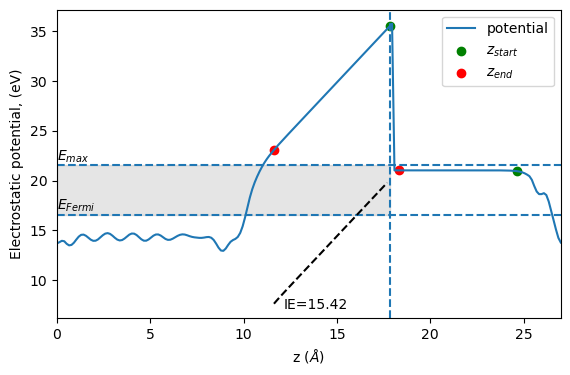

In [3]:
IE_H2 = 15.42
fig,sim=suggest_input_dictionary(working_directory,e_fermi, ionization_energies=[IE_H2])

## Extend the potential

original Nz = 210
extended Nz = 205


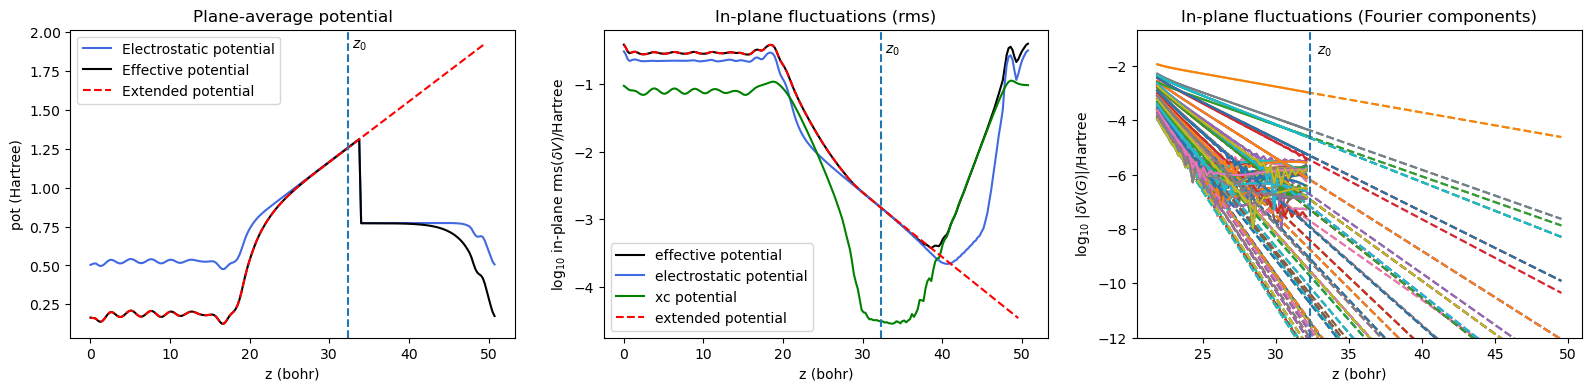

In [4]:
elec_potential,_ = sx_el_potential3D_cell (working_directory)
pot,_,_,cell = EXTRA.potential (sim).potential_cell ()
iz0 = sim['izstart_min']

new_z_max=50
fig, pot_ext = extend_potential(elec_potential / EXTRA.HARTREE_TO_EV, 
                                iz0, pot, cell, z_max=new_z_max,
                                izend=sim['izend'],dv_limit=1e-4,plotG=2)

z_ext,dz = np.linspace(0,
                    cell[2,2]*pot_ext.shape[2]/pot.shape[2] * BOHR_TO_AA,
                    pot_ext.shape[2],
                    endpoint=False,
                    retstep=True)

Override some parameters (finetuning)

In [5]:
#sim['izstart_min']=sim['izend']+10
sim['limit']=1e-10
sim['izstart_min']=int(40*BOHR_TO_AA/dz)-5
sim['z_max']=40

sim

{'working_directory': '/u/cfrey/calcs/Si100/4x2_addim_B_L0/20Vnm/wv',
 'z_max': 40,
 'izstart_min': 159,
 'izend': 90,
 'cutoff': 10,
 'limit': 1e-10,
 'E_fermi': 16.580343,
 'E_max': 21.580343,
 'ionization_energies': [15.42]}

Check potential again

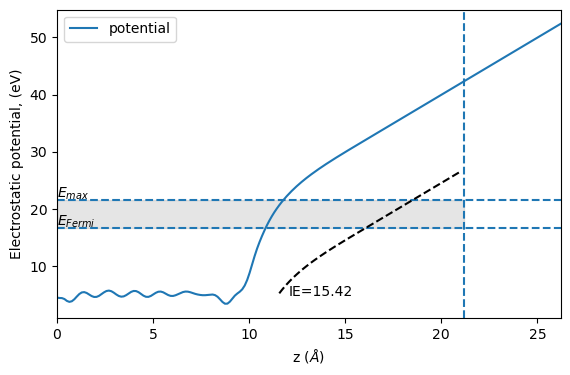

In [6]:
fig=potential_figure(sim,z_ext,np.mean(pot_ext,axis=(0,1)) * EXTRA.HARTREE_TO_EV)

## Check the wave functions

plotting i=139 ispin=0 ik=0
max. at ix,iy = 54, 15


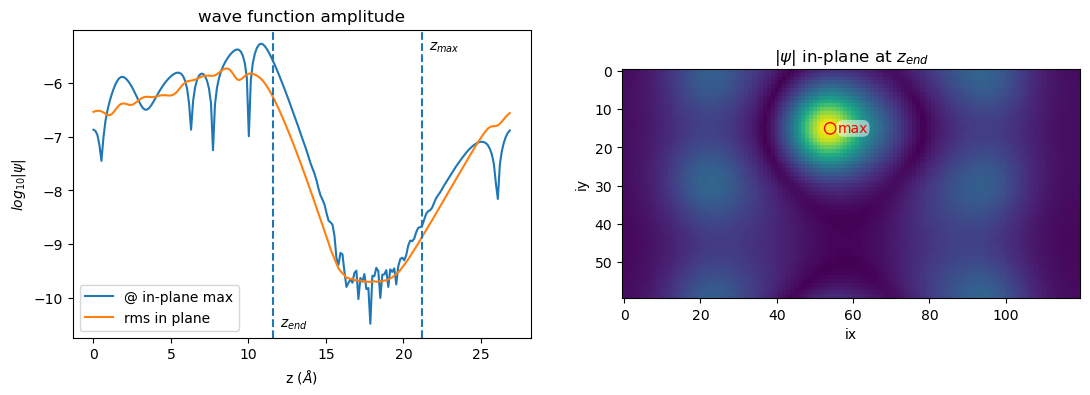

In [7]:
waves_reader = sx_nc_waves_reader(working_directory + "/waves.sxb")
fig=waves_figure(sim,waves_reader,n_plot=2,compute_extra=False)

Compute EXTRA for one trial function to ensure that EXTRA works for this case

plotting i=139 ispin=0 ik=23
max. at ix,iy = 54, 15
Computing EXTRA wave...


/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.10/site-packages/scipy/optimize/_nonlin.py:368: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
/u/cfrey/devel/python-test/EXTRA_FIM/data_utils/plotting.py:172: RuntimeWarning: divide by zero encountered in log10
  np.log10(psi_extra_abs[ix, iy, :-1]),


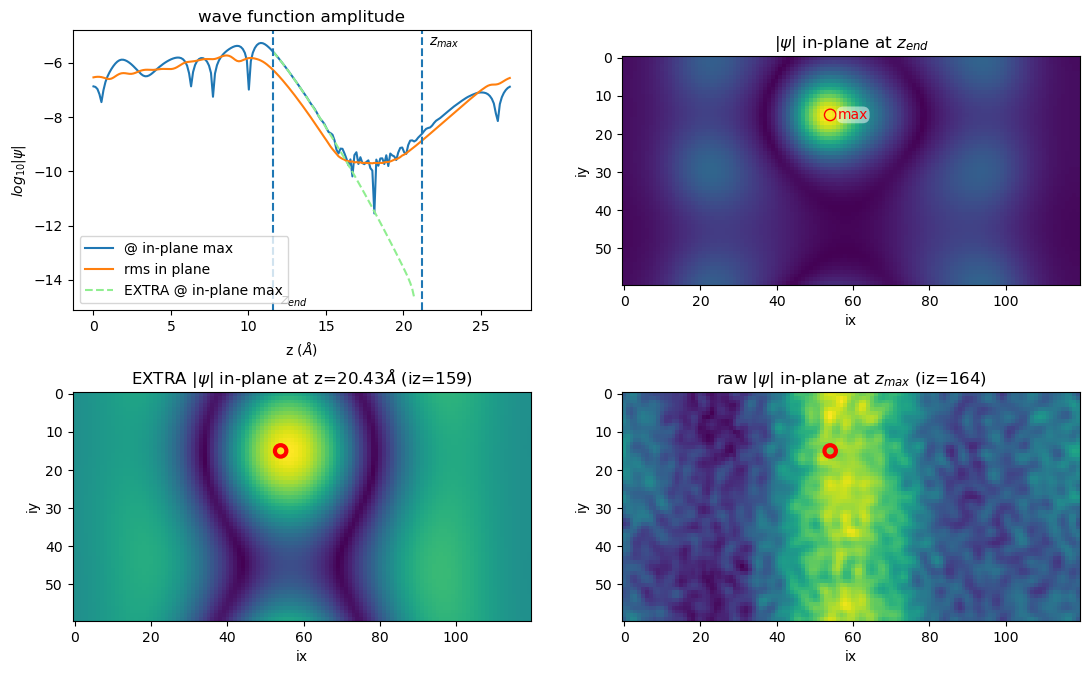

In [9]:
fig=waves_figure(sim,waves_reader,n_plot=4,compute_extra=True,pot=pot_ext,ik=23)

# Setup pyiron jobs

In [10]:
from pyiron import Project
pr=Project('FIM_test')

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [20]:
job_list=pr.get_jobs(columns=['job'])['job']

In [21]:
sim['iz_ext_from'] = iz0
sim['z_ext'] = new_z_max
for ik in range(waves_reader.nk):
    job_name=f'Si4x2_addim_B_L0_20Vnm_k{ik}'
    if job_name in job_list: continue
    job = pr.create_job(pr.job_type.ScriptJob,job_name)
    job.script_path=os.path.join(os.getcwd(), "FIMjob.ipynb")
    sim['ik']=ik
    job.input.update(sim)
    job.server.queue= 's_cmfe'
    job.server.cores= 1
    job.run()

In [22]:
table=pr.job_table()
table

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
18,21621028,finished,None,Si4x2_addim_B_L0_20Vnm_k0,/Si4x2_addim_B_L0_20Vnm_k0,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.580020,2024-02-11 11:28:50.699736,2789.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
13,21621029,finished,None,Si4x2_addim_B_L0_20Vnm_k1,/Si4x2_addim_B_L0_20Vnm_k1,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.576193,2024-02-11 11:28:38.291950,2776.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
17,21621030,finished,None,Si4x2_addim_B_L0_20Vnm_k2,/Si4x2_addim_B_L0_20Vnm_k2,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.562505,2024-02-11 11:30:00.601468,2859.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
22,21621031,finished,None,Si4x2_addim_B_L0_20Vnm_k3,/Si4x2_addim_B_L0_20Vnm_k3,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.575199,2024-02-11 11:30:00.596317,2859.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
14,21621032,finished,None,Si4x2_addim_B_L0_20Vnm_k4,/Si4x2_addim_B_L0_20Vnm_k4,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.583820,2024-02-11 11:28:36.708939,2775.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
11,21621033,finished,None,Si4x2_addim_B_L0_20Vnm_k5,/Si4x2_addim_B_L0_20Vnm_k5,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.561277,2024-02-11 11:28:09.042720,2747.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
12,21621034,finished,None,Si4x2_addim_B_L0_20Vnm_k6,/Si4x2_addim_B_L0_20Vnm_k6,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.566618,2024-02-11 11:28:14.067652,2752.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
7,21621035,finished,None,Si4x2_addim_B_L0_20Vnm_k7,/Si4x2_addim_B_L0_20Vnm_k7,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:21.577186,2024-02-11 11:28:19.289815,2757.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
16,21621036,finished,None,Si4x2_addim_B_L0_20Vnm_k8,/Si4x2_addim_B_L0_20Vnm_k8,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:36.667934,2024-02-11 11:28:42.797036,2766.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None
15,21621037,finished,None,Si4x2_addim_B_L0_20Vnm_k9,/Si4x2_addim_B_L0_20Vnm_k9,/cmmc/u/,cfrey/tests/pytest/Si100-FIM/FIM_test/,2024-02-11 10:42:36.662983,2024-02-11 11:28:32.316581,2755.0,cfrey@cmti001#1#s_cmfe,Script,0.1,None,None


# Collect partial results from jobs

In [23]:
import h5py
FIM_total = dict ()
zFIM_total=dict()

for ik in range(waves_reader.nk):
    job_name=f'Si4x2_addim_B_L0_20Vnm_k{ik}'
    trow = table[table['job'] == job_name]
    subjobdir = trow['projectpath'].iat[0]+'/' + trow['project'].iat[0] + \
                '/' + trow['job'].iat[0] + '_hdf5/' + trow['subjob'].iat[0]
    print (f'Loading ik={ik}')
    with h5py.File(f'{subjobdir}/partial_dos{ik}.h5') as handle:
        for IE in sim['ionization_energies']:
            fim_k = np.asarray(handle[f'IE={IE}'])
            zfim_k = np.asarray(handle[f'zIE={IE}'])
            if IE not in FIM_total:
                FIM_total[IE] = np.zeros_like(fim_k)
                zFIM_total[IE] = np.zeros_like(zfim_k)
            FIM_total[IE]  += fim_k
            zFIM_total[IE] += zfim_k          

Loading ik=0
Loading ik=1
Loading ik=2
Loading ik=3
Loading ik=4
Loading ik=5
Loading ik=6
Loading ik=7
Loading ik=8
Loading ik=9
Loading ik=10
Loading ik=11
Loading ik=12
Loading ik=13
Loading ik=14
Loading ik=15
Loading ik=16
Loading ik=17
Loading ik=18
Loading ik=19
Loading ik=20
Loading ik=21
Loading ik=22
Loading ik=23


# Plotting

FIM intensity on FFT mesh

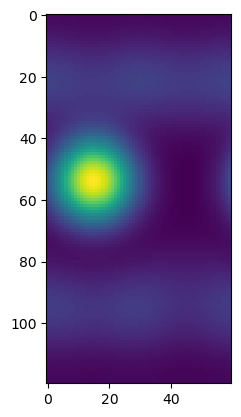

In [24]:
plt.imshow(FIM_total[15.42])

z-resolved contributions to FIM image

Text(0, 0.5, 'FIM contribution')

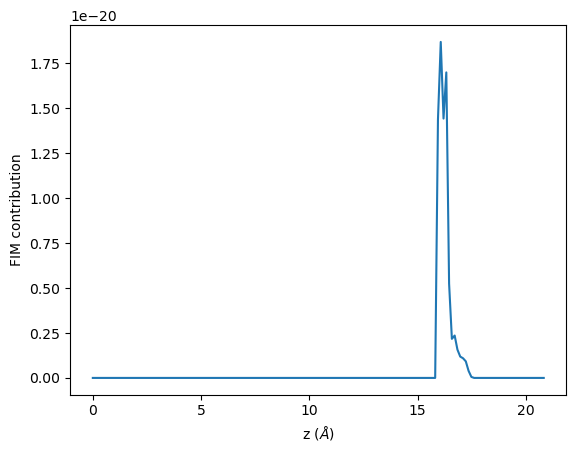

In [26]:
plt.plot(z_ext[:zFIM_total[15.42].shape[2]], np.mean(zFIM_total[15.42],axis=(0,1)))
plt.xlabel("z ($\AA$)")
plt.ylabel("FIM contribution")

energy-resolved contributions to FIM image (same as above, but different x-axis)

Text(0, 0.5, 'FIM contribution')

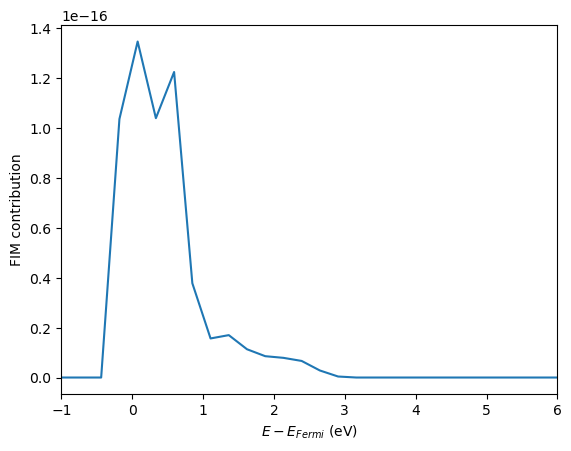

In [31]:
V1 = np.mean(pot_ext[:,:,:,0],axis=(0,1)) * EXTRA.HARTREE_TO_EV - e_fermi - 15.42
plt.plot(V1[:zFIM_total[15.42].shape[2]], np.sum(zFIM_total[15.42],axis=(0,1)))
plt.xlim([-1,6])
plt.xlabel("$E-E_{Fermi}$ (eV)")
plt.ylabel("FIM contribution")

## Plot FIM image in cartesian coordinates (with atoms)

Fourier interpolation

In [32]:
ex = EXTRA.extra_waves(sim)

In [33]:
xp =np.linspace(0,50,250)
yp= np.linspace(0,50,250)
#xp = np.linspace(0, fim_simulation.cell[0, 0], fim_simulation.Nx)
#yp = np.linspace(0, fim_simulation.cell[1, 1], fim_simulation.Ny)
FIM_image_ex_all=np.zeros([xp.shape[0],yp.shape[0]],dtype=np.complex128)

# interpolation of DFT_total3
#prho_rec_ex_all= np.fft.ifft2(all_totals_extra[21.5])
prho_rec_ex_all= np.fft.ifft2(FIM_total[15.42])

for ix in range(xp.shape[0]):
    for iy in range(yp.shape[0]):
        x=xp[ix]
        y=yp[iy]
        phase_1=np.exp(-1j*(ex.gk_1[:,0]*x+ex.gk_1[:,1]*y))
        phase_2= np.exp(-1j*(ex.gk_2[:,0]*x+ex.gk_2[:,1]*y))
        phase=np.outer(phase_1,phase_2)
        FIM_image_ex_all[ix,iy] =np.sum(prho_rec_ex_all.flatten()*phase.flatten())

Load atomic structure

In [34]:
import pyiron_atomistics.sphinx.structure
struct = pyiron_atomistics.sphinx.structure.read_atoms (working_directory+'/../relaxedStr.sx')
toplayer=[x for x in struct if (x.position[2]>8 and x.position[2]<15)]

Plot FIM + atomic positions

(0.0, 26.45886054515)

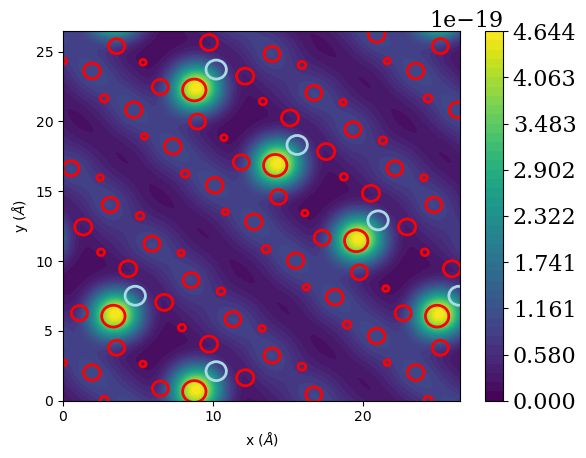

In [36]:
#plt.figure(figsize=[6.5,4])
vmax_lev=np.max(FIM_image_ex_all.real)
xp_AA = xp*BOHR_TO_AA
yp_AA = yp*BOHR_TO_AA
plt.contourf(xp_AA,yp_AA,FIM_image_ex_all.real.T,vmin=0,vmax=vmax_lev,levels=np.linspace(0,vmax_lev,41))
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] ='serif'
plt.xlabel('x ($\AA$)')
#plt.xticks([0,5,10,15,20,25])
plt.ylabel('y ($\AA$)')
plt.colorbar()
chem_color = { 'Si' : 'red', 'B' : 'lightblue' }
def inrange(x,x_space):
    return x >= x_space[0] and x <= x_space[-1]
for I in range(-5,6):
    for J in range(-5,6):
        X = (waves_reader.cell[0,0] * I + waves_reader.cell[0,1] * J) * BOHR_TO_AA
        Y = (waves_reader.cell[1,0] * I + waves_reader.cell[1,1] * J) * BOHR_TO_AA
        for a in toplayer:
            x,y = a.position[0:2]
            col = chem_color[a.symbol]
    #plt.text(x,y, a.symbol, style='normal',fontsize=14,color=col)
            if inrange(X+x,xp_AA) and inrange(Y+y,yp_AA):
                plt.gca().add_patch(
                    matplotlib.patches.Circle((X+x,Y+y), 0.3*(a.position[2]-7.5), fill=False, ec=col, lw=2)
                )
plt.xlim(xp_AA[0],xp_AA[-1])
plt.ylim(yp_AA[0],yp_AA[-1])
#plt.text(toplayer[8][0],toplayer[8][1], 'Ta', style='normal',fontsize=14,color='black')